Classification Models

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from xgboost import XGBClassifier

In [3]:
# import classification data
X_test = pd.read_csv('x_test_class.csv')
X_train = pd.read_csv('X_train_class.csv')
full_y_test = pd.read_csv('y_test_class.csv')
full_y_train = pd.read_csv('y_train_class.csv')

In [4]:
# label
timeframe = 'P+7'
y_test = full_y_test[timeframe]
y_train = full_y_train[timeframe]

Optimizing XGBoost Hyperparameters

In [13]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import randint, uniform, loguniform

# format xgb parameters into dictionary for ease of function insert
def extract_xgb_params(search_cv, step_name="clf"):
# get formatter optimal xgb parameters
    params = {}
    for k, v in search_cv.best_params_.items():
        # strip 'clf__' if present
        if k.startswith(step_name + "__"):
            k = k.split("__", 1)[1]
        if isinstance(v, np.generic):
            v = v.item()
        params[k] = v
    return params

def get_optimal_hyperparams(X_train, y_tr):
    # class balancing
    pos = int((y_tr == 1).sum())
    neg = int((y_tr == 0).sum())
    spw = neg / max(1, pos)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            n_estimators=2000,     
            random_state=42,
            n_jobs=-1
        ))
    ])

    # hyperparameter search space
    param_dist = {
        "clf__learning_rate": loguniform(0.01, 0.2),
        "clf__max_depth": randint(3, 9),
        "clf__min_child_weight": loguniform(1e-1, 10),
        "clf__subsample": uniform(0.6, 0.4),
        "clf__colsample_bytree": uniform(0.6, 0.4),
        "clf__gamma": uniform(0.0, 5.0),
        "clf__reg_alpha": loguniform(1e-8, 1e1),
        "clf__reg_lambda": loguniform(1e-3, 1e1),
        "clf__scale_pos_weight": [1.0, spw, np.sqrt(spw)],  
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=60,                      
        scoring="average_precision",    
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True                     
    )

    rs.fit(X_train, y_tr)

    xgb_params = extract_xgb_params(rs, step_name="clf")
    xgb_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators":2000
    })

    print("Best CV score (PR-AUC):", rs.best_score_)
    return(xgb_params)

In [14]:
# set model parameters
logreg = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, C=1.0, class_weight="balanced"))
])

linsvm = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler()),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(C=1.0, class_weight="balanced"),
        cv=3, 
        method="isotonic"
    ))
])

hgb = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", HistGradientBoostingClassifier(
        max_depth=3, learning_rate=0.05, max_iter=500, random_state=0
    ))
])

# evaluate metrics
# return a list (to be appended to a dataframe afterwards)
def report(y_true, p, name, timeframe):
    auc  = roc_auc_score(y_true, p)
    pr   = average_precision_score(y_true, p)
    yhat = (p >= 0.5).astype(int)
    acc  = accuracy_score(y_true, yhat)
    f1   = f1_score(y_true, yhat)
    return [name, auc, pr, acc, f1, timeframe]

def run_tr_and_test(X_train, X_test, full_y_train, full_y_test, xgb_params,  timeframe='P+1'):
    y_test = full_y_test[timeframe]
    y_train = full_y_train[timeframe]
    # xgboost
    imp_xgb = SimpleImputer(strategy="median").fit(X_train)
    Xtr_xgb = imp_xgb.transform(X_train)
    # create a stratified test set from train set
    Xt_tr, Xt_val, yt_tr, yt_val = train_test_split(Xtr_xgb, y_train, test_size=0.1, random_state=42, stratify=y_train)

    # using optimized parameters
    xgb = XGBClassifier(**xgb_params)

    # fitting models
    logreg.fit(X_train, y_train)
    linsvm.fit(X_train, y_train)
    hgb.fit(X_train, y_train)

    xgb.fit(
        Xt_tr, yt_tr,
        eval_set=[(Xt_val, yt_val)],
        verbose=False
    )

    # predict on test set
    def proba(model, X):
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)[:,1]
        return model.predict_proba(X)[:,1]

    p_logreg = proba(logreg, X_test)
    p_linsvm = proba(linsvm, X_test)
    p_hgb    = proba(hgb,    X_test)
    p_xgb    = xgb.predict_proba(imp_xgb.transform(X_test))[:,1]

    metric_list = []
    metric_list.extend([
        report(y_test, p_logreg, "LogReg", timeframe),
        report(y_test, p_linsvm, "LinSVM", timeframe),
        report(y_test, p_hgb, "HistGB", timeframe),
        report(y_test, p_xgb, "XGBoost", timeframe)]
    )
    return(metric_list)

In [27]:
# results function
def get_results(X_train, X_test, y_train, y_test):
    results_list = []
    for timeframe in ['P+1', 'P+7', 'P+14']:
        print(f"Fitting for timeframe {timeframe}.")
        filtered_y_train = y_train[timeframe]
        xgb_params = get_optimal_hyperparams(X_train, filtered_y_train)
        results_list.extend(run_tr_and_test(X_train, X_test, y_train, y_test, xgb_params, timeframe))
    results_df = pd.DataFrame(results_list, columns=['name', 'AUC', 'PR-AUC', 'ACC', 'F1', 'timeframe'])
    return(results_df)

In [ ]:
# get results for full dataset
results_df = get_results(X_train, X_test, full_y_train, full_y_test)
results_df

Fitting for timeframe P+1.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.5174430475940128
Fitting for timeframe P+7.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.606356402515356
Fitting for timeframe P+14.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.7181121478572738


,name,AUC,PR-AUC,ACC,F1,timeframe
0,LogReg,0.516554,0.443707,0.520626,0.519258,P+1
1,LinSVM,0.513871,0.451213,0.553343,0.076471,P+1
2,HistGB,0.582936,0.519686,0.568990,0.439926,P+1
3,XGBoost,0.565724,0.490536,0.549075,0.477759,P+1
4,LogReg,0.550589,0.568161,0.553343,0.577957,P+7
5,LinSVM,0.546941,0.561196,0.546230,0.650602,P+7
6,HistGB,0.568356,0.576894,0.571835,0.631579,P+7
7,XGBoost,0.592323,0.617135,0.573257,0.633252,P+7
8,LogReg,0.535912,0.700941,0.527738,0.596107,P+14
9,LinSVM,0.519871,0.693217,0.682788,0.811496,P+14


In [30]:
# training + testing with stratified feature dataset
# P0 and segment features only
X_train_filtered1 = X_train[['P0', 'seg_share', 'seg_unique', 'seg_entropy']]
X_test_filtered1 = X_test[['P0', 'seg_share', 'seg_unique', 'seg_entropy']]

results_df2 = get_results(X_train_filtered1, X_test_filtered1, full_y_train, full_y_test)
results_df2

Fitting for timeframe P+1.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.47300664039265694
Fitting for timeframe P+7.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.5740175521875858
Fitting for timeframe P+14.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.6977303145966092


,name,AUC,PR-AUC,ACC,F1,timeframe
0,LogReg,0.486725,0.422992,0.502134,0.474474,P+1
1,LinSVM,0.496108,0.429917,0.560455,0.000000,P+1
2,HistGB,0.544320,0.474591,0.557610,0.391389,P+1
3,XGBoost,0.567450,0.503694,0.576102,0.404000,P+1
4,LogReg,0.448241,0.497445,0.475107,0.458150,P+7
5,LinSVM,0.455163,0.510379,0.514936,0.674308,P+7
6,HistGB,0.530774,0.560631,0.532006,0.594328,P+7
7,XGBoost,0.542989,0.567863,0.550498,0.608911,P+7
8,LogReg,0.511659,0.677473,0.523471,0.608187,P+14
9,LinSVM,0.516265,0.685289,0.682788,0.811496,P+14


In [ ]:
# training + testing with stratified feature dataset
# P0, segment and UoM features
X_train_filtered2 = X_train[[
    'seg_share', 'seg_unique', 'seg_entropy', 'uom_COUNT',
    'uom_CRYPTO', 'uom_CUR_NONUSD', 'uom_CUR_USD', 'uom_FX_PAIR',
    'uom_OTHER', 'uom_PER_SHARE', 'uom_PHYS_UNIT', 'uom_PURE_PCT',
    'uom_SHARES', 'n_currencies', 'has_nonusd', 'usd_share_of_currency'
]]
X_test_filtered2 = X_test[[
    'seg_share', 'seg_unique', 'seg_entropy', 'uom_COUNT',
    'uom_CRYPTO', 'uom_CUR_NONUSD', 'uom_CUR_USD', 'uom_FX_PAIR',
    'uom_OTHER', 'uom_PER_SHARE', 'uom_PHYS_UNIT', 'uom_PURE_PCT',
    'uom_SHARES', 'n_currencies', 'has_nonusd', 'usd_share_of_currency'
]]

results_df3 = get_results(X_train_filtered2, X_test_filtered2, full_y_train, full_y_test)
results_df3

Fitting for timeframe P+1.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.4691657484278422
Fitting for timeframe P+7.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.5671080022542009
Fitting for timeframe P+14.
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV score (PR-AUC): 0.7038514593426085


,name,AUC,PR-AUC,ACC,F1,timeframe
0,LogReg,0.470368,0.408933,0.476529,0.455621,P+1
1,LinSVM,0.457965,0.407996,0.533428,0.083799,P+1
2,HistGB,0.518001,0.453244,0.543385,0.388571,P+1
3,XGBoost,0.500136,0.438515,0.509246,0.366972,P+1
4,LogReg,0.495150,0.540935,0.500711,0.494964,P+7
5,LinSVM,0.504078,0.543583,0.503556,0.619411,P+7
6,HistGB,0.522394,0.544938,0.529161,0.594859,P+7
7,XGBoost,0.488403,0.524433,0.496444,0.616883,P+7
8,LogReg,0.535725,0.694874,0.524893,0.595642,P+14
9,LinSVM,0.539140,0.699755,0.682788,0.811496,P+14


In [ ]:
# export resulting tables
# count = 0
# for results in [results_df, results_df2, results_df3]:
#     results.to_csv(f'results_{count}.csv', index=False)
#     count+=1

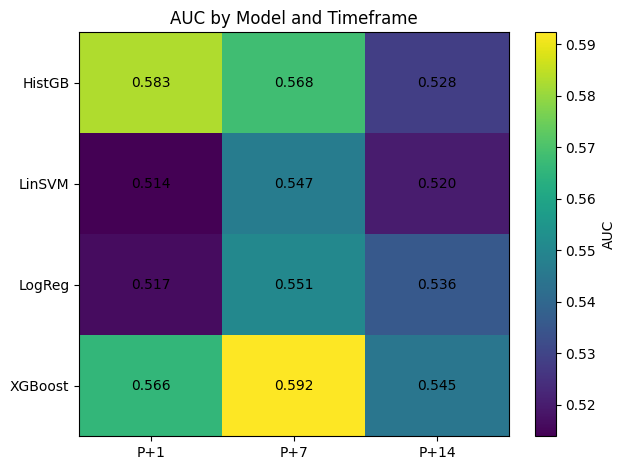

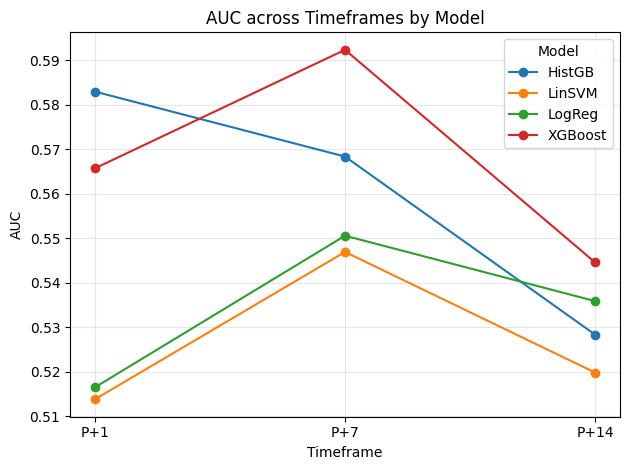

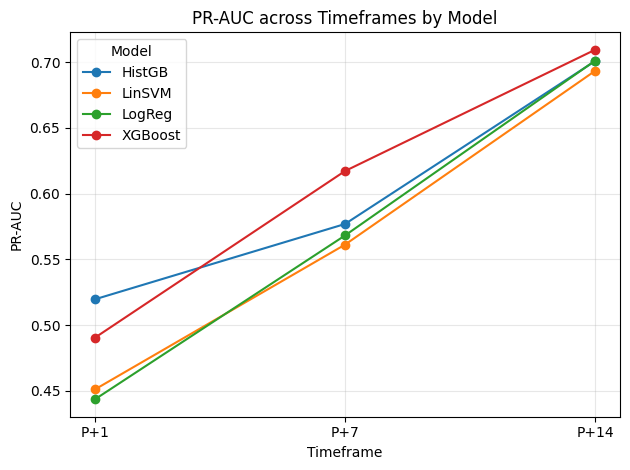

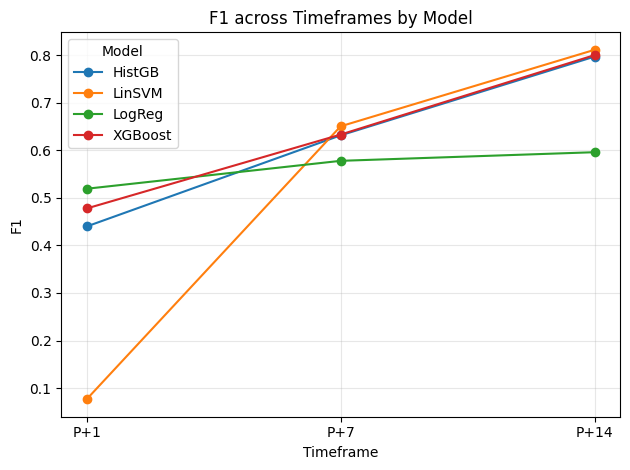

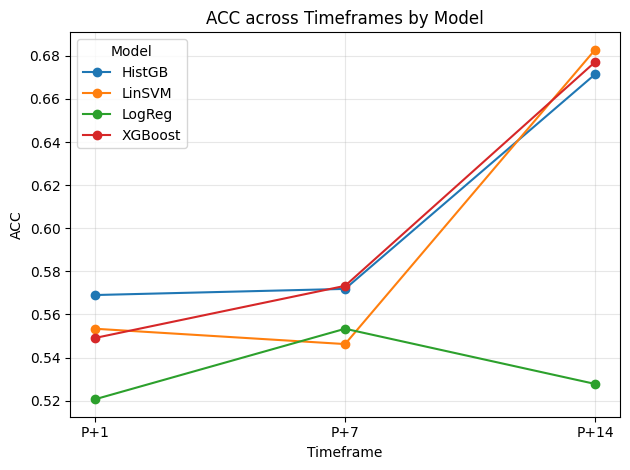

In [ ]:
import matplotlib.pyplot as plt

res = results_df.copy()

# ensure timeframe order
order = pd.CategoricalDtype(categories=['P+1','P+7','P+14'], ordered=True)
res['timeframe'] = res['timeframe'].astype(order)

# auc heatmap: model x timeframe
tbl = res.pivot_table(index='name', columns='timeframe', values='AUC', observed=True)
fig = plt.figure()
im = plt.imshow(tbl.values, aspect='auto')
plt.xticks(range(tbl.shape[1]), tbl.columns)
plt.yticks(range(tbl.shape[0]), tbl.index)
# annotate with values
for i in range(tbl.shape[0]):
    for j in range(tbl.shape[1]):
        v = tbl.values[i, j]
        if pd.notna(v):
            plt.text(j, i, f"{v:.3f}", ha='center', va='center')
plt.title('AUC by Model and Timeframe')
plt.colorbar(im, label='AUC')
plt.tight_layout()
plt.show()

# line graphs: metric vs timeframe
def plot_metric_lines(df, metric, tf_order=('P+1','P+7','P+14')):
    fig = plt.figure()
    for model, g in df.groupby('name'):
        g = g.set_index('timeframe').reindex(tf_order)
        plt.plot(tf_order, g[metric].values, marker='o', label=model)
    plt.xlabel('Timeframe')
    plt.ylabel(metric)
    plt.title(f'{metric} across Timeframes by Model')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

plot_metric_lines(res, 'AUC')
plot_metric_lines(res, 'PR-AUC')
plot_metric_lines(res, 'F1')
plot_metric_lines(res, 'ACC')